In [1]:
%load_ext autoreload
%autoreload 2

## import

In [2]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import torch

from src.config import load_config
from src.models import build_mlp
from src.metrics import DEFAULT_REGRESSION_METRICS
from src.trainer import Trainer
from src.evaluate import evaluate_on_npz
from src.utils import print_tensor
from src.visu import plot_pred_vs_true, plot_residuals

## Config

In [3]:
root_exp_dir = Path("runs/real_dataset_experiment")
config_path = root_exp_dir / 'hparams' / 'config.yaml'
assert config_path.exists(), f"Config file not found: {config_path}"
print(f"Loading config from: {config_path}  ")
cfg = load_config(config_path)
cfg.print()

Loading config from: runs/real_dataset_experiment/hparams/config.yaml  

===== Current Configuration =====
model:
  input_dim: 6
  hidden_dims:
  - 128
  - 128
  activation: relu
  dropout: 0.1
  output_dim: 1
data:
  dataset: real
  npz_path: data/preprocessed/cleaned_x_y_hot.npz
  n_samples: 3000
  noise_std: 0.1
  val_ratio: 0.2
  batch_size: 64
  seed: 42
optim:
  name: adam
  lr: 0.001
  weight_decay: 0.0
  momentum: 0.9
train:
  num_epochs: 100
  log_interval: 5
  device: null
logging:
  root_dir: ./runs
  experiment_name: real_dataset_experiment
  subdir_checkpoints: checkpoints
  subdir_logs: logs
  subdir_hparams: hparams
checkpoint:
  save_best: true
  save_last: false
  monitor: val_loss
  mode: min
cv:
  n_splits: 1
  shuffle: true
  seed: 42




## Trainer

In [4]:
# Model
model = build_mlp(cfg.model)
ckpt_path = root_exp_dir / 'checkpoints' / 'best.pt'
ckpt = torch.load(ckpt_path, map_location='cpu')
model.load_state_dict(ckpt['model_state'], strict=True)

# Trainer
trainer = Trainer(
    model=model,
    optimizer=None,
    loss_fn=torch.nn.MSELoss(),
    train_cfg=cfg.train,
    logging_cfg=cfg.logging,
    checkpoint_cfg=cfg.checkpoint,
    metrics=DEFAULT_REGRESSION_METRICS,
)


In [5]:
TEST_NPZ_PATH = "data/preprocessed/cleaned_x_y_hot.npz"

scaler_stats_path = root_exp_dir / 'hparams' / 'scaler_stats.npz'
out_dict = evaluate_on_npz(
    trainer,
    TEST_NPZ_PATH,
    scaler_stats_path,
    sample_rate=0.1,
    batch_size=64,
    norm_method="minmax",
    return_raw_outputs=True,
)

[INFO] Sampled 866 / 8665 from data/preprocessed/cleaned_x_y_hot.npz

Test Evaluation
Loss: 0.345732
     mse: 0.345732
     mae: 0.413816
    rmse: 0.587990
      r2: 0.993041


In [7]:
test_loss = out_dict['loss']
test_metrics = out_dict['metrics']
preds = out_dict['preds']
targets = out_dict['targets']

print_tensor(preds, "preds")
print_tensor(targets, "targets")

preds          : shape: torch.Size([866]), min: 1.1595, max: 35.9579, mean: 8.1403, std: 7.0826
targets        : shape: torch.Size([866]), min: 0.7817, max: 33.8542, mean: 8.1851, std: 7.0526


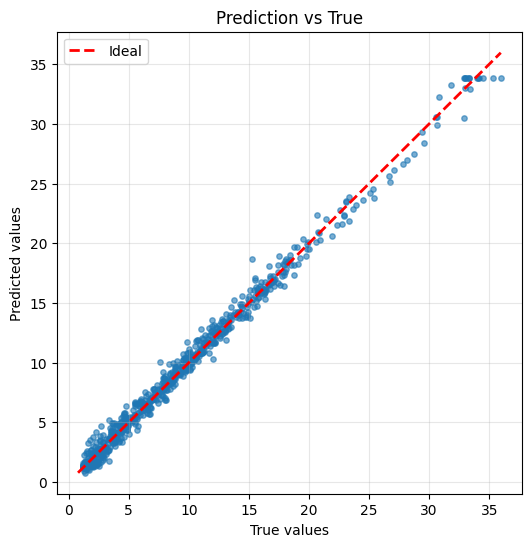

In [8]:
kwargs = {"figsize": (6,6), "s": 15}
plot_pred_vs_true(preds, targets, **kwargs)

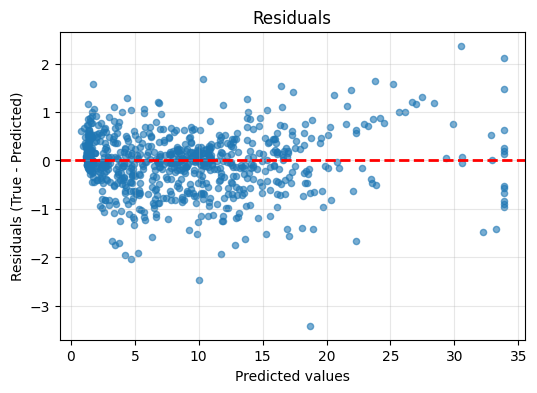

In [9]:
plot_residuals(preds, targets)